In [1]:
import pandas as pd
from lab3 import *
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data/Steel_industry_data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
np.set_printoptions(linewidth=1000)
data.head()

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


In [2]:
data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.sort_values(by='date', inplace=True)

data['day'] = data['date'].dt.weekday
data['month'] = data['date'].dt.month
data['time'] = data['date'].dt.time
data = data.drop(columns=['date', 'WeekStatus', 'Day_of_week'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   Load_Type                             35040 non-null  object 
 8   day                                   35040 non-null  int32  
 9   month                                 35040 non-null  int32  
 10  time                                  35040 non-null  object 
dtypes: float64(6), int3

In [3]:
data['TimeStamp'] = data['time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
data = data.drop(columns=['time'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   Load_Type                             35040 non-null  object 
 8   day                                   35040 non-null  int32  
 9   month                                 35040 non-null  int32  
 10  TimeStamp                             35040 non-null  int64  
dtypes: float64(6), int3

In [4]:
from sklearn.preprocessing import LabelEncoder

scaler = StandardScaler()
numeric_features = ['Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM', 'TimeStamp']
data[numeric_features] = scaler.fit_transform(data[numeric_features])

label_encoder = LabelEncoder()
data['Load_Type'] = label_encoder.fit_transform(data['Load_Type'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35040 entries, 95 to 35038
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  float64
 7   Load_Type                             35040 non-null  int32  
 8   day                                   35040 non-null  int32  
 9   month                                 35040 non-null  int32  
 10  TimeStamp                             35040 non-null  float64
dtypes: float64(8), int3

In [5]:
x = data.drop(columns='Load_Type').values
y = pd.get_dummies(data['Load_Type']).values

seq_len = 4
X_seq = []
Y_seq = []

for i in range(len(x) - seq_len):
    X_seq.append(x[i:i + seq_len])
    Y_seq.append(y[i + seq_len-1])

X_seq = np.array(X_seq)
Y_seq = np.array(Y_seq)

x_train, x_test, y_train, y_test = train_test_split(X_seq, Y_seq, test_size=0.1, random_state=3)

In [6]:
learning_rate = 0.05
batch_size = 32
epochs = 40
weights = 0.2

layers = [
    RNN(input_size=None, hidden_size=24, output_size=24, not_last=True, weights=weights),
    ReLU(),
    RNN(input_size=24, hidden_size=12, output_size=10, not_last=False, weights=weights),
    ReLU(),
    DenseLayer(10, 3, weights=weights),
    Softmax()
]

model = NeuralNetwork(layers, CategoricalCrossEntropy())
model.train(x_train, y_train, epochs, learning_rate, batch_size)

y_pred = model.predict(x_test)
f1_score = calculate_f1_score(y_test, y_pred)
print(f"F1 Score after test: {f1_score}")
print(calculate_precision_recall(y_test, y_pred))

Epoch 1/25 - Mean Loss: 1.0205
Epoch 2/25 - Mean Loss: 0.9110
Epoch 3/25 - Mean Loss: 0.6179
Epoch 4/25 - Mean Loss: 0.5485
Epoch 5/25 - Mean Loss: 0.5117
Epoch 6/25 - Mean Loss: 0.4804
Epoch 7/25 - Mean Loss: 0.4533
Epoch 8/25 - Mean Loss: 0.4341
Epoch 9/25 - Mean Loss: 0.4208
Epoch 10/25 - Mean Loss: 0.4113
Epoch 11/25 - Mean Loss: 0.4056
Epoch 12/25 - Mean Loss: 0.3997
Epoch 13/25 - Mean Loss: 0.3943
Epoch 14/25 - Mean Loss: 0.3864
Epoch 15/25 - Mean Loss: 0.3795
Epoch 16/25 - Mean Loss: 0.3738
Epoch 17/25 - Mean Loss: 0.3664
Epoch 18/25 - Mean Loss: 0.3624
Epoch 19/25 - Mean Loss: 0.3587
Epoch 20/25 - Mean Loss: 0.3524
Epoch 21/25 - Mean Loss: 0.3484
Epoch 22/25 - Mean Loss: 0.3443
Epoch 23/25 - Mean Loss: 0.3390
Epoch 24/25 - Mean Loss: 0.3352
Epoch 25/25 - Mean Loss: 0.3304
F1 Score after test: 0.7946937759964964
([0.9650388457269701, 0.6589403973509934, 0.769811320754717], [0.9775154581225407, 0.7938829787234043, 0.6296296296296297])


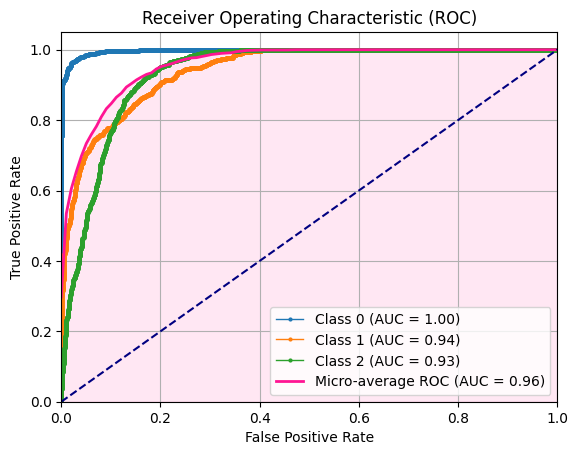

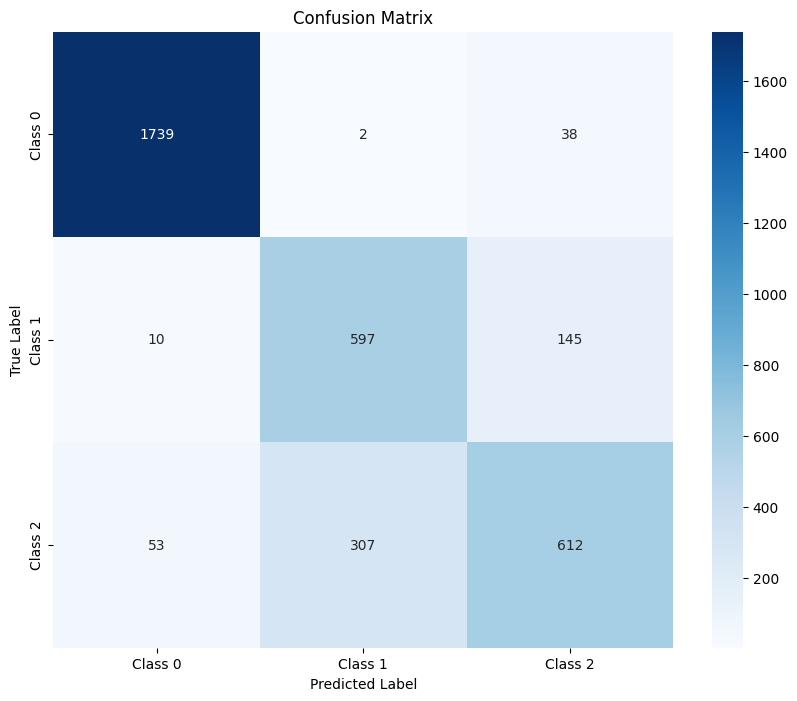

  Class  Precision   Recall
Class 0   0.965039 0.977515
Class 1   0.658940 0.793883
Class 2   0.769811 0.629630


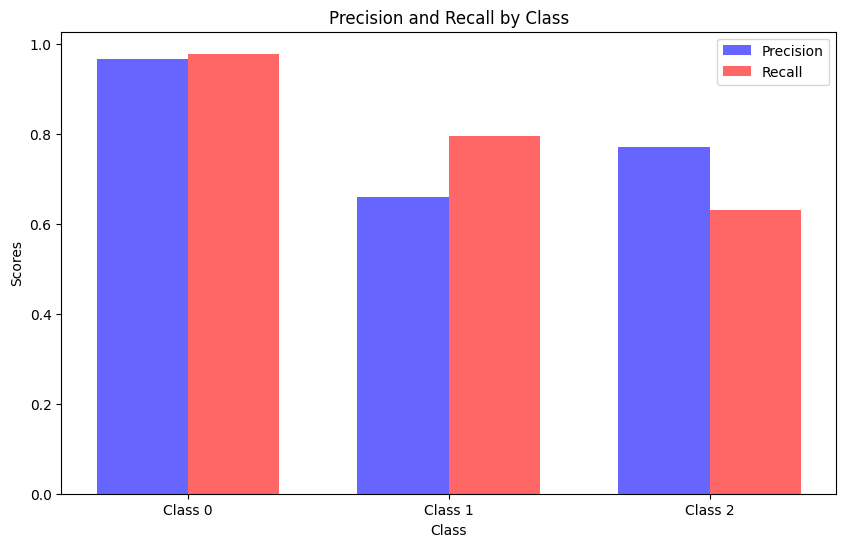

In [7]:
draw_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print_precision_recall_table(y_test, y_pred)

In [12]:
learning_rate = 0.08
batch_size = 64
epochs = 25
weights = 0.2

layers = [
    LSTM(input_size=None, hidden_size=64, output_size=64, not_last=True, weights=weights),
    ReLU(),
    LSTM(input_size=64, hidden_size=32, output_size=16, not_last=False, weights=weights),
    ReLU(),
    DenseLayer(16, 3, weights=weights),
    Softmax()
]

model = NeuralNetwork(layers, CategoricalCrossEntropy())

model.train(x_train, y_train, epochs, learning_rate, batch_size)

y_pred = model.predict(x_test)
f1_score = calculate_f1_score(y_test, y_pred)
print(f"F1 Score after test: {f1_score}")
print(calculate_precision_recall(y_test, y_pred))

Epoch 1/25 - Mean Loss: 1.0133
Epoch 2/25 - Mean Loss: 0.9464
Epoch 3/25 - Mean Loss: 0.7530
Epoch 4/25 - Mean Loss: 0.5816
Epoch 5/25 - Mean Loss: 0.5283
Epoch 6/25 - Mean Loss: 0.5075
Epoch 7/25 - Mean Loss: 0.4934
Epoch 8/25 - Mean Loss: 0.4814
Epoch 9/25 - Mean Loss: 0.4705
Epoch 10/25 - Mean Loss: 0.4601
Epoch 11/25 - Mean Loss: 0.4511
Epoch 12/25 - Mean Loss: 0.4434
Epoch 13/25 - Mean Loss: 0.4369
Epoch 14/25 - Mean Loss: 0.4314
Epoch 15/25 - Mean Loss: 0.4267
Epoch 16/25 - Mean Loss: 0.4218
Epoch 17/25 - Mean Loss: 0.4187
Epoch 18/25 - Mean Loss: 0.4169
Epoch 19/25 - Mean Loss: 0.4139
Epoch 20/25 - Mean Loss: 0.4097
Epoch 21/25 - Mean Loss: 0.4131
Epoch 22/25 - Mean Loss: 0.4130
Epoch 23/25 - Mean Loss: 0.4065
Epoch 24/25 - Mean Loss: 0.4230
Epoch 25/25 - Mean Loss: 0.4064
F1 Score after test: 0.7531932224466807
([0.9655172413793104, 0.6317880794701987, 0.6597222222222222], [0.9443507588532883, 0.6343085106382979, 0.684156378600823])


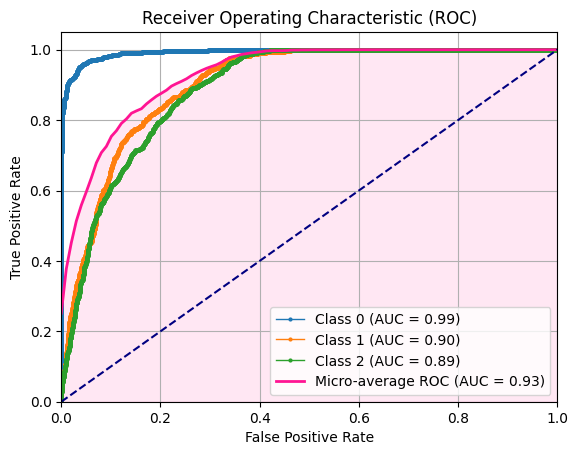

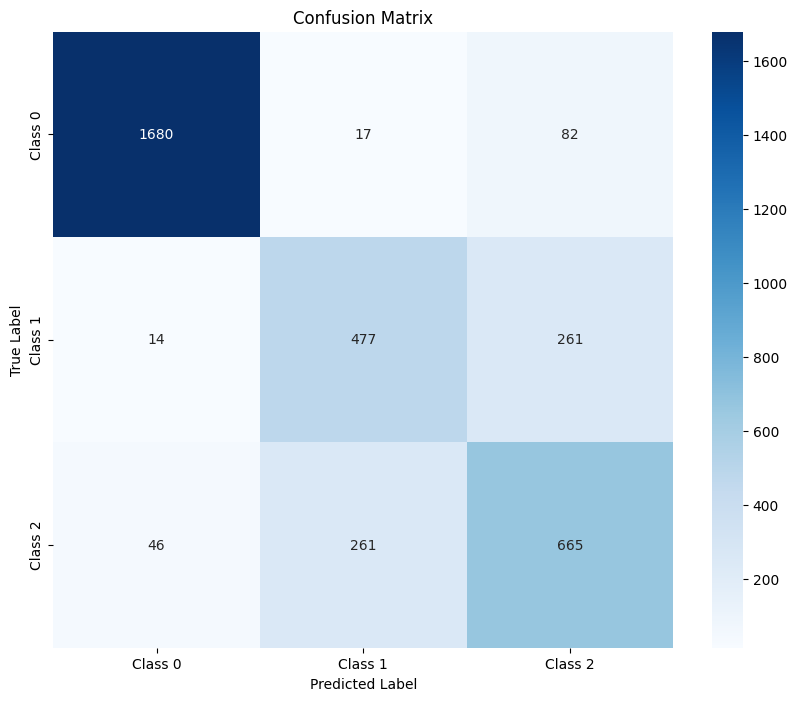

  Class  Precision   Recall
Class 0   0.965517 0.944351
Class 1   0.631788 0.634309
Class 2   0.659722 0.684156


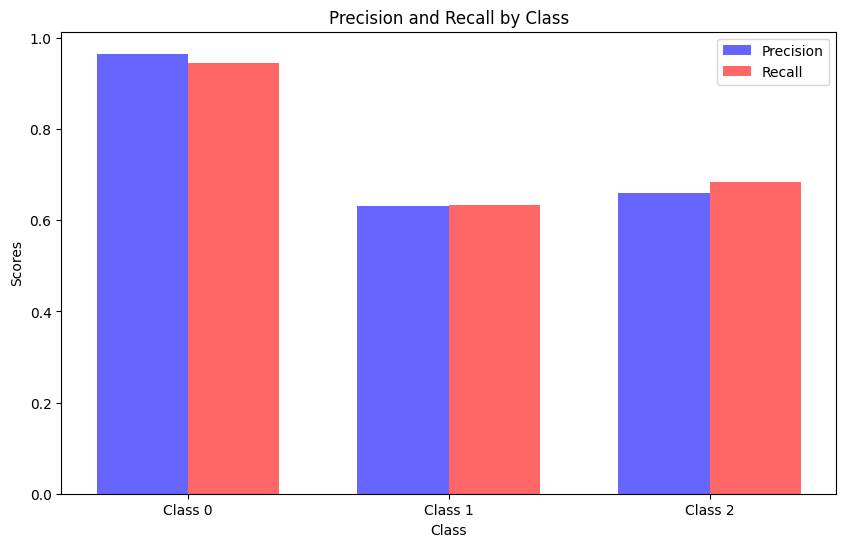

In [13]:
draw_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print_precision_recall_table(y_test, y_pred)

In [10]:
learning_rate = 0.03
batch_size = 32
epochs = 25
weights = 0.3

layers = [
    GRU(input_size=None, hidden_size=32, output_size=32, not_last=True, weights=weights),
    ReLU(),
    GRU(input_size=32, hidden_size=16, output_size=12, not_last=False, weights=weights),
    ReLU(),
    DenseLayer(12, 3, weights=weights),
    Softmax()
]

model = NeuralNetwork(layers, CategoricalCrossEntropy())
model.train(x_train, y_train, epochs, learning_rate, batch_size)

y_pred = model.predict(x_test)
f1_score = calculate_f1_score(y_test, y_pred)
print(f"F1 Score after test: {f1_score}")
print(calculate_precision_recall(y_test, y_pred))

Epoch 1/25 - Mean Loss: 0.8603
Epoch 2/25 - Mean Loss: 0.6355
Epoch 3/25 - Mean Loss: 0.5613
Epoch 4/25 - Mean Loss: 0.5228
Epoch 5/25 - Mean Loss: 0.4946
Epoch 6/25 - Mean Loss: 0.4731
Epoch 7/25 - Mean Loss: 0.4563
Epoch 8/25 - Mean Loss: 0.4422
Epoch 9/25 - Mean Loss: 0.4296
Epoch 10/25 - Mean Loss: 0.4191
Epoch 11/25 - Mean Loss: 0.4103
Epoch 12/25 - Mean Loss: 0.4022
Epoch 13/25 - Mean Loss: 0.3953
Epoch 14/25 - Mean Loss: 0.3891
Epoch 15/25 - Mean Loss: 0.3835
Epoch 16/25 - Mean Loss: 0.3783
Epoch 17/25 - Mean Loss: 0.3737
Epoch 18/25 - Mean Loss: 0.3680
Epoch 19/25 - Mean Loss: 0.3637
Epoch 20/25 - Mean Loss: 0.3589
Epoch 21/25 - Mean Loss: 0.3541
Epoch 22/25 - Mean Loss: 0.3497
Epoch 23/25 - Mean Loss: 0.3450
Epoch 24/25 - Mean Loss: 0.3410
Epoch 25/25 - Mean Loss: 0.3371
F1 Score after test: 0.7658366646081646
([0.8767326732673267, 0.6821345707656613, 0.8164251207729468], [0.9955030916245081, 0.7819148936170213, 0.5216049382716049])


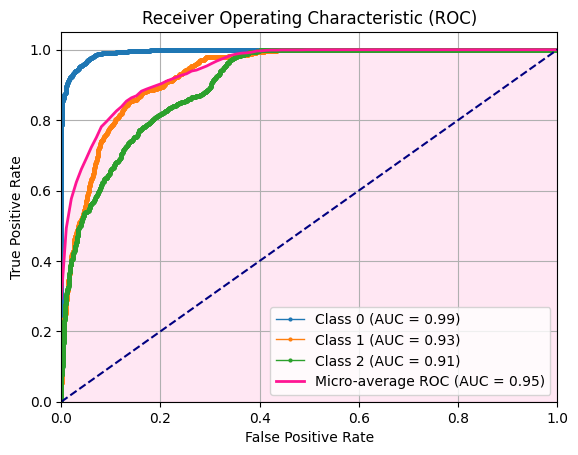

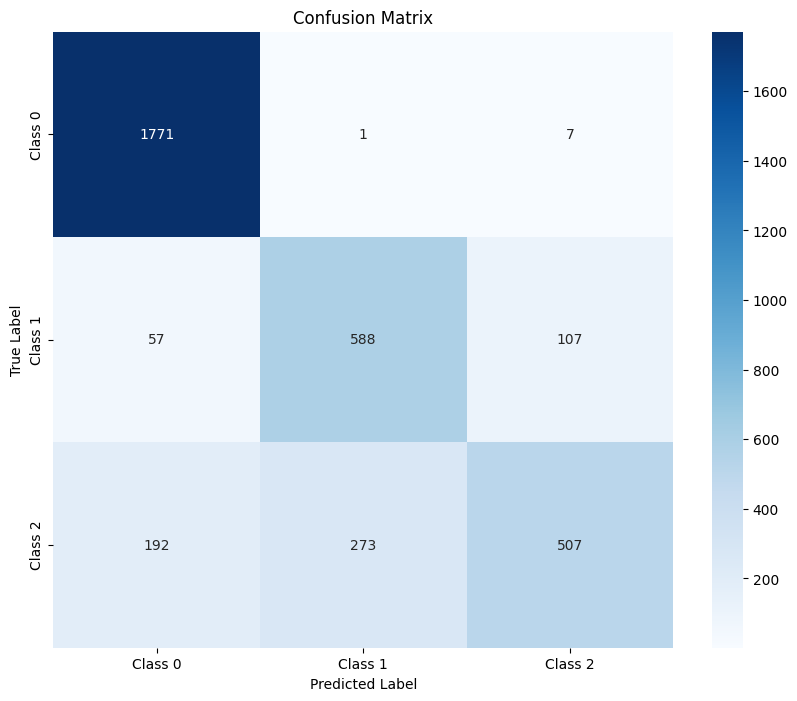

  Class  Precision   Recall
Class 0   0.876733 0.995503
Class 1   0.682135 0.781915
Class 2   0.816425 0.521605


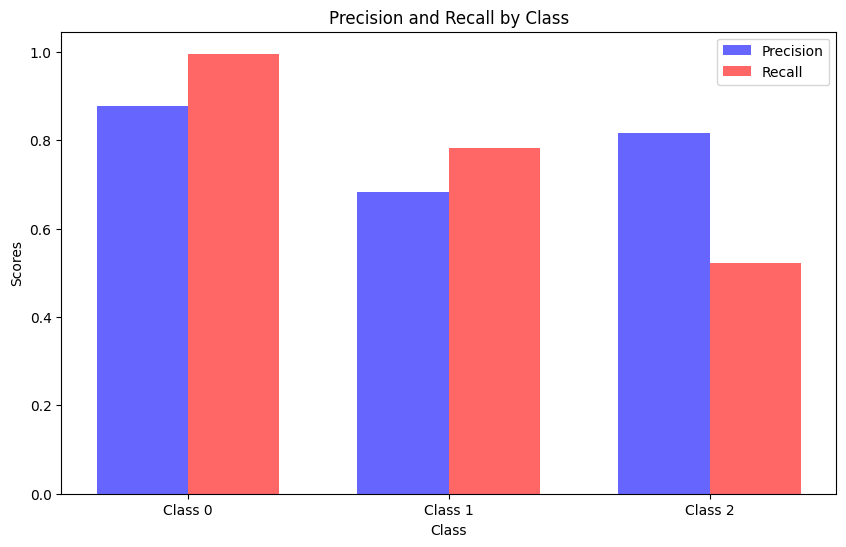

In [11]:
draw_roc_curve(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
print_precision_recall_table(y_test, y_pred)